# How to use Jupyter's notebooks to create validation forms

This notebook introduces TRUST(and BALTIKS) validation forms using jupyter, and shows the main possibilities offered by "trustutils" API and Jupyter's notebooks. 

Notebook for validation forms requires a particular environment, which is set up by TRUST.

## <u>What is a validation form?</u>

A validation form has two contexts:

* If made by a **user**, it will, for example:
  + explain the goal of the study
  + explain test case setup (geometry, boundary conditions, initial conditions, problem being solved,...) 
  + runs specific datafiles
  + extract relevent results
  + show results (figures/tables/graphs/...) with further comparisons if needed
  + with conclusions

* If made by a **developer**, it will for example:
  + explain the goal of the study
  + explain performed devlopements
  + run test cases
  + extract relevant results and display figures/tables/graphs/... with further comparisons if needed
  + with conclusions

In both cases, the validation form will help into:
* the understanding of developments and validation
* the understanding of tests being performed
and users and developer's will be able to re-run the validation form and generate a pdf report.

Furthermore, when the validation form is merged in TRUST or another BALTIK, it will:
* be run often to ensure non-regression
* probably be used to generate non-regression test cases (run on 3 time steps)
* help future users/developers to understand what is being tested

## <u>Important remarks</u>

* **You should edit the notebook in your web browser** and not in a text editor
* Auto compeltion is available for trustutils functions and for code in general by hitting "Tab" key.
* Autosave is disabled by default, **do not forget to save you work**.
* By default, the output of notebooks (text, curves and VisIt images) are not saved to avoid polluting the version control system (git). This can be changed using the instruction below in one of your code cells\
<code>#run.saveFormOutput()</code>\
This option must be activated if you want to export your notebook in PDF format (File -> Download as ...) with the results of the code cells, for this you should add in a code cell the previous command uncommented.
* By default, all instructions (creation of test cases from template, running test cases, execution of scripts if needed) are executed in the build directory. If you need to access to this directory explicitly, you can refer to it with:\
<code>run.BUILD_DIRECTORY   ## Contains the absolute path of the build directory.</code>

## <u>Presentation features</u>


This notebook presents examples of use of the main available features, which allows to: 

* create/run validation cases (TRUST or baltik test cases) through the [<code>run</code> module](#jupyter.run-module);
  + To create/run test cases, see [common parameters](#General-parameters)

* plot graphs, curves and generate tables from output files with the [<code>plot</code> module](#jupyter.plot-module);
  + To plot graphs, see 
* create VisIt renderings with the [<code>visit</code> module](#Visitutils-function)
* we will also see how to include a png figure

The complete html documentation of these tools is available with trust -index

## <u>jupyter.run module</u>

### <u>General parameters</u>

Test cases that need to be executed in the form **should** be added through the API offered by the <code>run</code> module: 

In [ ]:
from trustutils import run

Some classical introduction blocks (Author, Short description, TRUST version used) can be generated automatically

In [ ]:
# Declaration of Author and (optionally) date 
run.introduction("First Test","24/05/2023")

# In case of a very long description, it is better to write directly in a markdown cell without using this function
run.description("Lanching my first automatic test with Jupyter-notebook")

# Declaration of the TRUST version
run.TRUST_parameters("v1.9.2_beta")

# Do not forget, you can save output as mentionned in the "Important Remarks" by uncommenting the following line:
run.saveFormOutput()


## Introduction 
 Validation made by : First Test



 Report created : 24/05/2023



 Report generated 24/05/2023

### Description 
Lanching my first automatic test with Jupyter-notebook

### TRUST parameters 
 * Version TRUST: v1.9.2_beta
 * Binary used: /volatile/catC/linkai/TRIOCFD/TrioCFD_opt (built in directory /volatile/catC/linkai/TRIOCFD/share/Validation/Rapports_automatiques/Multiphase/Front_tracking_discontinu/SampleFormJupyter/build)

### Management of TRUST Cases
First of all, you should import run module from trustutils:\
<code>**from** trustutils **import** run</code>

Then, the <code>addCase</code> method allows to create an object of type <code>TRUSTCase</code> which has methods to copy and/or modify the datafile.

By default, during the 1st call, it:
* copies the entire <code>src</code> directory into <code>build</code>
* invokes the <code>prepare</code> script if it exists (on new forms, users are encouraged to perform the maneuvers usually done in the prepare directly in a Jupyter code cell)

See the <code>run.TRUSTSuite</code> class to control this more finely.

At the beginning, or for fine tuning, it can be useful to reset everything to 0, i.e. delete the build directory, and empty the list of cases to be executed using:

In [ ]:
run.reset()   ## Delete the build directory and empty the list of cases to be executed

Then we specify datafiles to run and create others if needed by changing some parameters in the datafile.

If we want to add a test case to run, we need to specify:
* the directory in which the case is located inside src folder. Below the test case "grad_u_transpose_3d.data" is within src, hence the directory should be "."; from the other part, "Couette_cylindrique.data" is inside "src/Couette" folder so its relative path is "Couette".
* the datafile's name. Below, datafiles are named grad_u_transpose_3d.data and Couette_cylindrique.data
* the desired number of processors (default value=1, i.e: sequential datafile). In case of parallel calculation the partitioning with the requested number of processors is called with the <code>partition()</code> function 

In [ ]:
# code starts with ! will be excuted in bash

!ls src/grad_u_transpose_3d.data
!ls src/Couette/*.data


Couette = run.addCase("Couette","Couette_cylindrique.data",nbProcs=2)
Couette.partition()

# for files direct under src/, put "." in the path, etc
run.addCase(".","grad_u_transpose_3d.data")

src/grad_u_transpose_3d.data
src/Couette/Couette_cylindrique.data


It possible to use <code>addCaseFromTemplate</code> to generate test cases from your template data file using a dictionnary to substitute string starting with $.

Here for example, we:
* have a template datafile named diffusion.data, which mesh is generated using the internal TRUST mesher using:

`
Mailler dom
{
  Pave Cavite
  {
    Origine 0. 0.
    Nombre_de_Noeuds `**`$number $number`**`
    Longueurs 1. 1.
  }
  {
    Bord Gauche  X = 0.0   0.0  <= Y <= 1.0
    Bord Bas     Y = 0.0   0.0  <= X <= 1.0
    Bord Droit   X = 1.0   0.0  <= Y <= 1.0
    Bord Haut    Y = 1.0   0.0  <= X <= 1.0
  }
}`

* want to substitute **$number** (which corresponds to the number of mesh nodes in each direction in diffusion.data) by a number (here 8) in order to generate test case with specific mesh refinement.
* want to create the datafile diffusion.data in the directory "coarse"

so we use:

In [ ]:
run.addCaseFromTemplate("diffusion.data",directory="coarse",d={"number": 8})

Another possibility, we can create a datafile by keeping in a variable the TRUSTCase object to be able to manipulate it later:

In [ ]:
refined_data_file = run.addCaseFromTemplate("diffusion.data","fine",{"number": 32})

We can also use the method <code>copy</code> to manage the file tree in the build and substitute some text, the use the <code>addCase</code> method to add it to the list of test cases to be run:

In [ ]:
medium_data_file = refined_data_file.copy("NewData.data", directory="medium")
medium_data_file.substitute("Nombre_de_Noeuds 32 32","Nombre_de_Noeuds 16 16")
# The case can then be added to the list to be executed with addCase
run.addCase(medium_data_file)

Finally, to get the list of test cases that will be executed, add: 

In [ ]:
run.printCases()

### Test cases 
* Couette/Couette_cylindrique.data : 
* ./grad_u_transpose_3d.data : 
* coarse/diffusion.data : 
* fine/diffusion.data : 
* medium/NewData.data : 


Then the launching of the cases is done with the method <code>runCases</code>. For each case:

* the <code>pre_run</code> script, if any, is executed, 
* then the test case (<code>trust mydatafile.data</code>)
* and finally the <code>post_run</code> script if any
 
If a test case fails, the last 20 lines of the .err file are automatically displayed (you can for example try to modify the previous <code>substitute()</code> to make a case crash).

To run the test cases, call:

In [ ]:
run.runCases()

Running ...
  => A total of 5 cases were (successfully) run in 12.9s.


<code>run.runCases()</code> accepts two options:
* The 'verbose' option displays the output of TRUST. This is usually not wanted because it is already in the terminal\
<code>run.runCases(verbose=True)</code>
* The <code>preventConcurrent=True</code> option ensures that the cases will be executed in the order in which they have been registered. This is useful for example if test case 1 generates a .xyz file which is read in test case 2 to set initial conditions, in this case, we do not want to run both cases at the same time. Otherwise, if the Sserver is active, it will be automatically used.\
<code>run.runCases(preventConcurrent=True)</code>

And finally we can display the performance table for all executed test cases:

In [ ]:
run.tablePerf()

,host,system,Total CPU Time,CPU time/step,number of cells
Couette/Couette_cylindrique,is246146,Linux,10.012100,0.0190779,1876
./grad_u_transpose_3d,is246146,Linux,0.056923,0.0037775,756
coarse/diffusion,is246146,Linux,0.288791,0.000248073,49
fine/diffusion,is246146,Linux,1.304950,0.00117761,961
medium/NewData,is246146,Linux,0.510751,0.000453033,225
Total,,,12.173515,,


### <u>Additional functions</u>

The MEDCoupling environment can be automatically loaded with: 

In [ ]:
run.useMEDCoupling()
# Let's test it!
import medcoupling as mc
print(mc.DataArrayDouble([1,2,3]))

Name of double array : ""
Number of components : 1
Info of these components : ""   
Number of tuples : 3
Internal memory facts : 3/3
Data content :
Tuple #0 : 1 
Tuple #1 : 2 
Tuple #2 : 3 



Some additional script (other than prepare/pre_run/post_run) or a shell command can be executed from the notebook

In [ ]:
run.executeScript("extract_number_of_cells",verbose=1)
run.executeCommand("cat nb_cells",verbose=1)

./extract_number_of_cells
None
./fine/diffusion.data 961
./medium/NewData.data 225
./diffusion.data 1
./grad_u_transpose_3d.data 25
./coarse/diffusion.data 49
cat nb_cells
None


We can display the datafile and highlight a specific keyword, here, dom, using:

In [ ]:
medium_data_file.dumpDataset(["dom"])  # highlighting a specific word

 # PARALLEL OK #
 dimension 2
 Pb_conduction pb
 Domaine dom
 
 # BEGIN MESH #
 Mailler dom
 {
     Pave Cavite
     {
         Origine 0. 0.
         Nombre_de_Noeuds 16 16
         Longueurs 1. 1.
     }
     {
 	 Bord Gauche  X = 0.0   0.0  <= Y <= 1.0
         Bord Bas     Y = 0.0   0.0  <= X <= 1.0
         Bord Droit   X = 1.0   0.0  <= Y <= 1.0
         Bord Haut    Y = 1.0   0.0  <= X <= 1.0
     }
 }
 # END MESH #
 
 # BEGIN PARTITION
 Partition dom
 {
     partitionneur metis { Nb_parts 4 }
     larg_joint 1
     zones_name DOM
 }
 End
 END PARTITION #
 
 # BEGIN SCATTER
 Scatter DOM.Zones dom
 END SCATTER #
 
 VDF dis
 
 Schema_euler_implicite sch
 Read sch
 {
     tinit 0
     dt_max  1e-3
     dt_impr 1e-10
     seuil_statio 1e-8
     facsec 1e8
     solveur implicite
     {
         solveur gmres { diag seuil 1.e-13 nb_it_max 5 impr } 
     }
 }
 
 Associate pb dom
 Associate pb sch
 
 Discretize pb dis
 
 Read pb
 {
 
     solide {
         rho     Champ_Uniforme 1 1.
  

The method dumpDataset is specific to the file \*.data, to display an ascii file, it is possible to use the method:

In [ ]:
run.dumpText('extract_number_of_cells',list_keywords=["number_of_nodes","nbr_maille"])

 #!/bin/bash 
 rm -f nb_cells
 for f in `find -name "*.data"`
 do
   nbCells=""
   nbCells=`grep -i nombre_de_noeud $f | $TRUST_Awk '{print ($2-1)*($3-1)}'`
   [ "$nbCells" != "" ] && echo $f $nbCells >> nb_cells
 done
 exit 0



## <u>jupyter.plot module</u> 

### Graph plot

This module allows to display curves and other graphs from the TRUST probes and output files. It is based on matplotlib. 

We will see how to:
* plot a graph for a probe (single proble) using <code>addPoint</code> function
* plot a graph from a segment of probes using <code>addSegment</code> function
* add a curve using <code>add</code> function 
* make multiplots
* plot residuals

You can for example plot the time evolution of a field at a given point of the domain (which corresponds to a probe at a single point) using:

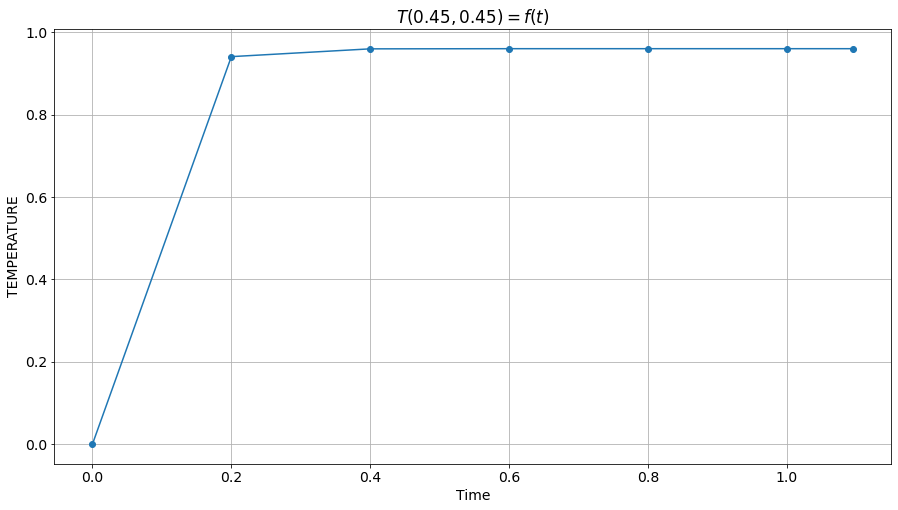

In [ ]:
from trustutils import plot

# Simple graph from point probe
Graph=plot.Graph("$T(0.45,0.45)=f(t)$",size=[15,8])
Graph.addPoint("fine/diffusion_TEMPERATURE_PROBE.son",marker='-o')

To plot a graph from many probe files, you can use:

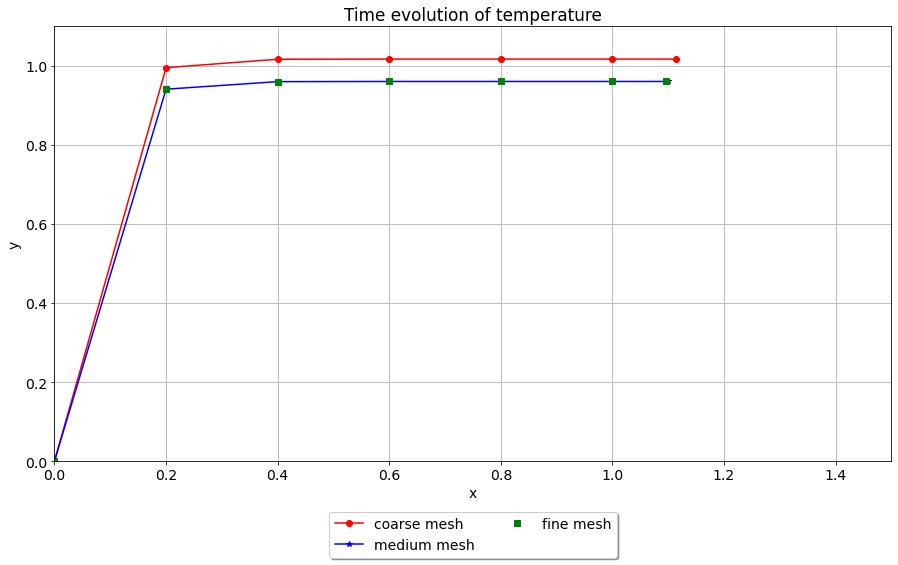

In [ ]:
from trustutils import plot
import numpy as np

# More complex graph
Graph=plot.Graph("Time evolution of temperature",size=[15,8])
Graph.addPoint("coarse/diffusion_TEMPERATURE_PROBE.son",label="coarse mesh",color="r",marker="-o")
Graph.addPoint("medium/NewData_TEMPERATURE_PROBE.son",label="medium mesh",color="b",marker="-*")
Graph.addPoint("fine/diffusion_TEMPERATURE_PROBE.son",label="fine mesh",color="g",marker="s")

# To add any curve, use the "add" method. 
#x=np.linspace(0,2,100)
#y=2*(x-1)*(x-1)
#Graph.add(x,y,label="Plot")

# The functions add, addPoint and addSegment take as options 
# the arguments of matplotlib.pyplot.plot
#y = np.exp(x)/3
#Graph.add(x,y,label="exp",linewidth=3.,marker='s',mfc='none')

# The legend function takes the arguments of matplotlib.pyplot.legend
Graph.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

# Method to change the axis titles.
Graph.label("x","y")

# Method to frame the plot.
# All parameters are not mandatory:
Graph.visu(xmin=0,xmax=1.5,ymin=0,ymax=1.1)

To add a graph plotting a segment of probes, and an analytical solution, you can use

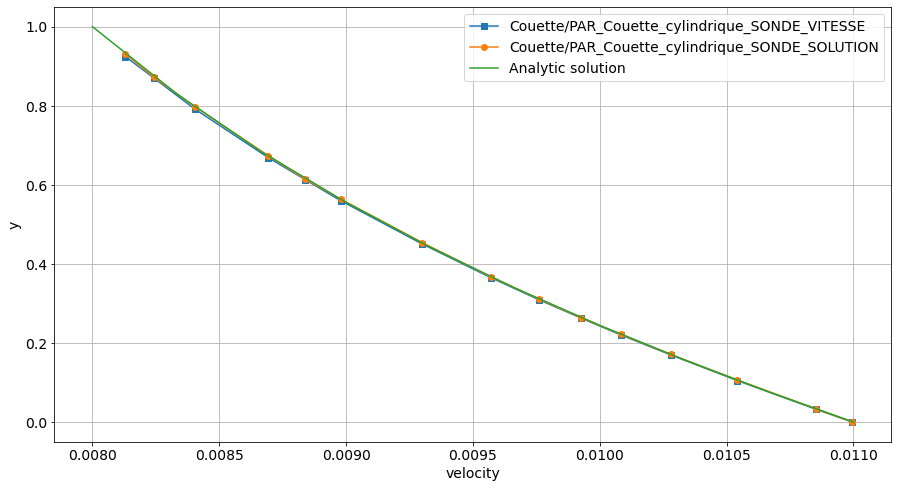

In [ ]:
from trustutils import plot
import numpy as np
import math

# To plot the variables of a segment of probes at a given time (by default, at the last time step), 
# the graph displays the closest value in the probe file. 
# The compo keyword corresponds to the index to plot for a field with several dimensions (e.g. velocity)
Graph=plot.Graph("Segment probe",size=[15,8])
Graph.addSegment("Couette/PAR_Couette_cylindrique_SONDE_VITESSE.son",compo=1,marker="-s")
Graph.addSegment("Couette/PAR_Couette_cylindrique_SONDE_SOLUTION.son",compo=0,marker="-o")


#Graph.addPlot([0,1])
x=np.linspace(0.008,0.011,10)
#y=-x*x+10
cst=0.005
y=0.003/3*(4/np.sqrt((x-0.005)*(x-0.005)+(cst-0.005)*(cst-0.005))-np.sqrt((x-0.005)*(x-0.005)+(cst-0.005)*(cst-0.005))/(0.003*0.003))
Graph.add(x,y,label="Analytic solution")
Graph.label("velocity","y")

# it is possible to add a function Y=f(X,Y) in addSegment and addPoint (can allow to calculate for example an error)

#def substraction(x,y):
#    return y - np.sin(np.pi*x)

#Graph.addSegment("fine/diffusion_TEMPERATURE_X.son",compo=0,label='segment probe',func=substraction)


To make a multiplot, you can use:

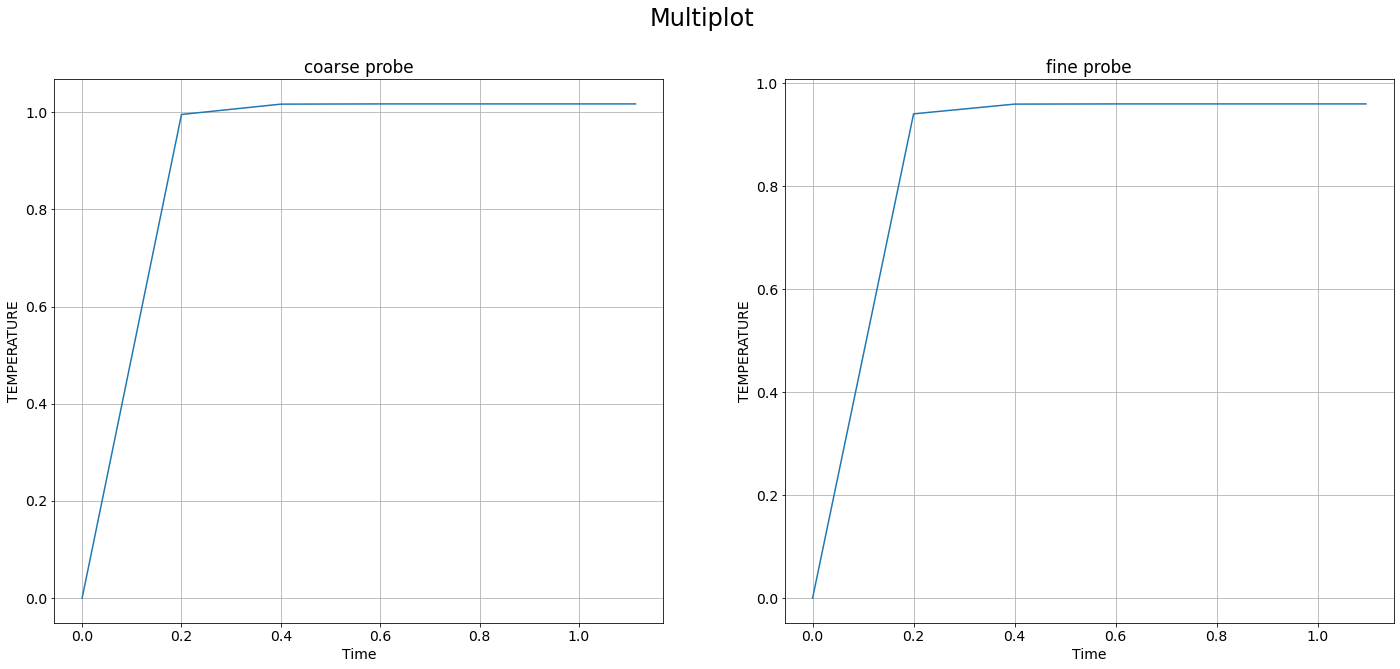

In [ ]:
from trustutils import plot
import numpy as np 

# We can arrange plots disposition with indice variable
Graph=plot.Graph(title="Multiplot",subtitle="coarse probe",nY=2)
Graph.addPoint("coarse/diffusion_TEMPERATURE_PROBE.son")

Graph.addPlot(1,"fine probe")
Graph.addPoint("fine/diffusion_TEMPERATURE_PROBE.son") 


To plot residuals, you can use:

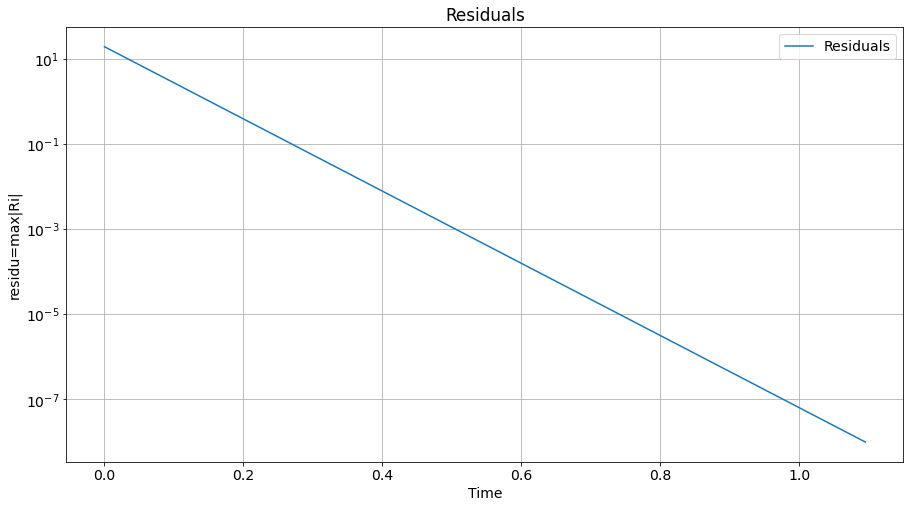

In [ ]:
# Residuals Plot
Graph=plot.Graph("Residuals",size=[15,8])
Graph.addResidu("fine/diffusion.dt_ev",label="Residuals")

# Method to change the axis scales
Graph.scale(yscale='log')

### Writing in a table

In [ ]:
from trustutils import plot
a = plot.Table(["mesh number", r"time", r"$L_{inf}$(error)"])

# If you want to load a file similar to a text file, 
# you can use the method plot.loadText("direction_of_file.txt")
nb_maille = plot.loadText("nb_cells", index_column=1, nb_column=1, dtype="str", transpose=True)

data = plot.loadText("coarse/diffusion_NORME_LINF.son", skiprows=0)
a.addLigne([[nb_maille[0][2],data[0][-1],data[1][-1]]],"coarse")

data = plot.loadText("fine/diffusion_NORME_LINF.son")
a.addLigne([[nb_maille[0][1],data[0][-1],data[1][-1]]],"medium")

data = plot.loadText("medium/NewData_NORME_LINF.son")
a.addLigne([[nb_maille[0][3],data[0][-1],data[1][-1]]],"fine")


display(a)

### Plot a VisIt visu

Visitutils is a module whose purpose is to help the users to obtain VisIt plots (2D or 3D results).

We will see how to:
* Plot a mesh using <code>showMesh</code>
* plot a field using <code>showField</code>
* Add a probe to check where it is located on the domain using checkProbe
* Use the Show class and its options to:
    * visualize the plot type options of VisIt (Pseudocolor,Histogram,Mesh,Contour...) 
    * make multiplots
    * adjust the view with <code>rotation3D</code>/<code>up3D</code>/<code>zoom3D</code>
    * define slice view with <code>slice2D</code>
    * apply standard VisIt command with <code>visitCommand</code>
* Used export_lata_base class to export properties and fields from lata files
* Implement an interactive widget to fine tuned visualization directly in the notebook. 


To plot a mesh, you can use:


In [ ]:
from trustutils import visit
visit.showMesh("fine/diffusion.lata","dom")

To vizualize a field, you can use:

In [ ]:
from trustutils import visit

# Simple command to visualize a field or mesh
visit.showField("fine/diffusion.lata","Pseudocolor","TEMPERATURE_ELEM_dom",plotmesh=False)

You can use Show class to apply more options

In [ ]:
from trustutils import visit

fig=visit.Show("fine/diffusion.lata","Pseudocolor","ERREUR_T_ELEM_dom")
#fig.addField("fine/diffusion.lata","Pseudocolor","")
# to visualize probes
fig.checkProbe("fine/diffusion_TEMPERATURE_DIAG.son",sizePoint=10,color="black")

# to add a list of viewing options
fig.visuOptions(['no_databaseinfo','no_legend'])

# To display the visu with the initialization visit.Show()
fig.plot()

To make a multiplot, you can use:

In [ ]:
from trustutils import visit

# Square Multiplot
fig=visit.Show("fine/diffusion.lata","Pseudocolor","TEMPERATURE_SOM_dom",plotmesh=False,title="multiplot",nY=2,nX=2)
fig.add("fine/diffusion.lata","Mesh","dom",xIndice=0,yIndice=1)
fig.add("coarse/diffusion.lata","Pseudocolor","TEMPERATURE_SOM_dom",plotmesh=False,xIndice=1,yIndice=0)
fig.add("coarse/diffusion.lata","Mesh","dom",xIndice=1,yIndice=1)
fig.plot()

to extract some relevant values from latafiles, you can use <code>export_lata_base</code>

In [ ]:
from trustutils import plot, visit 

# class export_lata_base to export profile or fields from lata files.
tmp=visit.export_lata_base("fine/diffusion.lata","Pseudocolor","ERREUR_T_ELEM_dom","fine")
tmp.maximun() # register value in Maxfine file
tmp=visit.export_lata_base("coarse/diffusion.lata","Pseudocolor","ERREUR_T_ELEM_dom","coarse")
tmp.maximun()  

MaxFine   =plot.loadText("Maxfine"   )
MaxCoarse =plot.loadText("Maxcoarse")

columns=["Max Error"]
t=plot.Table(columns)      
t.addLigne([[MaxFine]],"fine")    
t.addLigne([[MaxCoarse]],"coarse")    
display(t)

In [ ]:
# 3D Case
from trustutils import visit

# option time to select the frame we want to plot
fig=visit.Show("./grad_u_transpose_3d.lata", "Mesh", "dom", plotmesh=True,nY=2,iteration=0,title="Mesh")
# Possibility to vary the perspective with rotation3D, normal3D, up3D, zoom3D and zoom2D
fig.rotation3D([45,45,45])
fig.visuOptions(["no_axes","no_bounding_box","no_triad"])

# Zoom on the perpective and min, max value options
fig.add("./grad_u_transpose_3d.lata", "Pseudocolor", "PRESSION_PA_ELEM_dom",plotmesh=True,min=5.,max=6.3,yIndice=1,title="Zoom")
fig.normal3D([0.5,0.5,0.5])
fig.up3D([0,0,1])
fig.zoom3D([0.,0.,1.5])
fig.plot()


In [ ]:
fig=visit.Show("./grad_u_transpose_3d.lata", "Pseudocolor", "PRESSION_PA_ELEM_dom",iteration=0,plotmesh=True)
fig.addField("./grad_u_transpose_3d.lata", "Vector", "VITESSE_SOM_dom",plotmesh=True)
fig.rotation3D([45,45,45])

# Available Options
fig.blackVector()
fig.meshColor("red")

fig.plot()

fig = visit.Show("./grad_u_transpose_3d.lata", "Contour", "PRESSION_PA_ELEM_dom",title="Isovalues")
fig.rotation3D([45,45,45])
fig.meshTrans()
# Reproduction of visit commands
fig.visitCommand("ContourAtts = ContourAttributes()")
fig.visitCommand("ContourAtts.lineWidth = 2")
fig.visitCommand("ContourAtts.wireframe = 1")
fig.visitCommand("ContourAtts.contourNLevels = 15")
fig.visitCommand("SetPlotOptions(ContourAtts)")

fig.plot()

# It is also possible to use the option empty=True to build on an initially empty base
a=visit.Show(empty=True,title="slice2D")
a.visitCommand("OpenDatabase('grad_u_transpose_3d.lata', 0)")
a.visitCommand("DefineVectorExpression('v_proj_obli45', '{VITESSE_X_SOM_dom/2+VITESSE_Z_SOM_dom/2,VITESSE_Y_SOM_dom,VITESSE_X_SOM_dom/2+VITESSE_Z_SOM_dom/2}')")
a.visitCommand("AddPlot('Vector', 'v_proj_obli45', 1, 0)")

# Formation of a slice2D
a.slice(origin=[0,0,0],normal=[1,1,1.],type_op='slice2d')
a.visitCommand("VectorAtts = VectorAttributes()")
a.visitCommand("VectorAtts.useStride = 1")
a.visitCommand("VectorAtts.stride = 1")
a.visitCommand("VectorAtts.autoScale = 0")
a.visitCommand("VectorAtts.scale = 0.3")
a.visitCommand("SetPlotOptions(VectorAtts)")
a.visitCommand("DrawPlots()")
a.plot()


In case of difficulty, the cli (Command Line Interface) command history of a visu is saved in the file tmp_visit.py and can be replayed with <code>visit -cli -s tmp_visit.py</code>

## Jupyter-Widget Function 

<code>trustutils.widget</code> is a module that allows you to create an interactive widget in the notebook.

This can typically be used to fine-tune a visualization. Once all the parameters are set, we can keep in the final notebook only the corresponding <code>visit.Show</code> command to lighten the form (less heavy than the widget, and more portable).

In [ ]:
# To be used only for the finalization of the form, not for its final version!
from trustutils import widget

# alpha Version
widget.interface("./grad_u_transpose_3d.lata","Pseudocolor","PRESSION_PA_ELEM_dom") 

# include image

Two possibilities to include an image. The first one allows to change size and other parameters but it will not be included in the pdf when using Run_fiche -export_pdf. 

<img src="src/fig.png">

To get the image in the pdf report, you can use this command:
![](src/fig.png) 